In [64]:
import pandas as pd
import numpy as np
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt

#import catboost as catt
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold,GroupKFold,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split, KFold
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')


In [75]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00


# LOADING DATA 

In [38]:
data = pd.read_csv('/content/water_potability.csv')

## Data understanding

In [39]:
data.shape

(3276, 10)

In [40]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [41]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [42]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [43]:
percent_missing = data.isnull().sum() * 100/ len(data)
missing_value_train = pd.DataFrame({'column_name': data.columns,
                                  'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
ph,ph,14.987790
Hardness,Hardness,0.000000
Solids,Solids,0.000000
Chloramines,Chloramines,0.000000
Sulfate,Sulfate,23.840049
Conductivity,Conductivity,0.000000
Organic_carbon,Organic_carbon,0.000000
Trihalomethanes,Trihalomethanes,4.945055
Turbidity,Turbidity,0.000000
Potability,Potability,0.000000


In [44]:
data.fillna(inplace=True, method='bfill')

In [45]:
data.fillna(inplace=True, method='ffill')

In [46]:
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

# EDA 

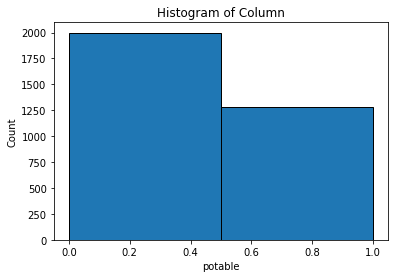

In [47]:
plt.hist(data['Potability'], bins=2, edgecolor='black', align='mid')
plt.xlabel('potable')
plt.ylabel('Count')
plt.title('Histogram of Column')
plt.show()

OUTLIERS IN DATA

In [48]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [49]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_iqr(data['Potability'])
print("Outliers from IQR method: ", len(sample_outliers))

Outliers from IQR method:  0


<AxesSubplot:xlabel='Solids'>

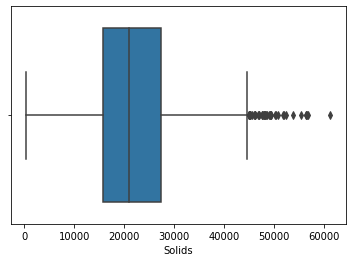

In [50]:
sns.boxplot((data['Solids']))

<AxesSubplot:xlabel='ph'>

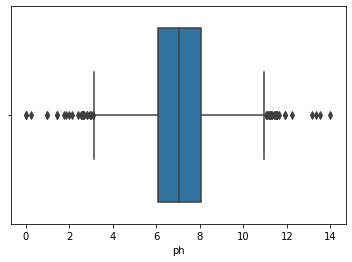

In [51]:
sns.boxplot((data['ph']))

### corelation

In [52]:
data.corr()['Potability'].sort_values()[data.corr()['Potability'].sort_values() < 0]

Organic_carbon   -0.030001
Sulfate          -0.022591
Hardness         -0.013837
Conductivity     -0.008128
Name: Potability, dtype: float64

In [53]:
data.corr()['Potability'].sort_values()[data.corr()['Potability'].sort_values() > 0]

ph                 0.000424
Turbidity          0.001581
Trihalomethanes    0.014336
Chloramines        0.023779
Solids             0.033743
Potability         1.000000
Name: Potability, dtype: float64

## MODDELING

In [54]:
X = data.iloc[:, 0:-1]

In [55]:
X.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,3.716080,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,356.886136,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,356.886136,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


In [56]:
y = data.iloc[:, -1]

In [57]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Potability, dtype: int64

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
X_train_scaled = st.fit_transform(X_train)
X_test_scaled = st.transform(X_test)

## random forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [61]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [62]:
y_pred_rfc = rfc.predict(X_test_scaled)

In [65]:
accuracy_score(y_pred_rfc, y_test)

0.711890243902439

<AxesSubplot:>

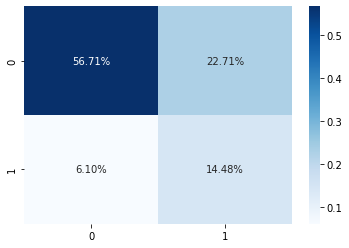

In [67]:
cf_matrix = confusion_matrix( y_pred_rfc, y_test)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## gradient boosting

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
gbc=GradientBoostingClassifier(n_estimators=2100,learning_rate=0.05,random_state=100,max_features=5 )

gbc.fit(X_train_scaled,y_train)

GradientBoostingClassifier(learning_rate=0.05, max_features=5,
                           n_estimators=2100, random_state=100)

In [73]:
y_pred_gbc = gbc.predict(X_test_scaled)

In [74]:
accuracy_score(y_pred_gbc, y_test)

0.6905487804878049

## Catboost

In [76]:
import catboost as catt

In [81]:
params = {'max_depth': 6, 'learning_rate': 0.054311625828468046, 'l2_leaf_reg': 0.023393133390917083,'iterations':1000}

In [82]:
model_cb = catt.CatBoostRegressor(**params,random_state=42)

In [83]:

model_cb.fit(X_train, y_train,eval_set = [(X_train, y_train),(X_test,y_test)], early_stopping_rounds = 500, 
           verbose = 200)

0:	learn: 0.4871232	test: 0.4871232	test1: 0.4822964	best: 0.4822964 (0)	total: 4.06ms	remaining: 4.06s
200:	learn: 0.3726628	test: 0.3726628	test1: 0.4485846	best: 0.4481802 (182)	total: 581ms	remaining: 2.31s
400:	learn: 0.3088434	test: 0.3088434	test1: 0.4499516	best: 0.4477311 (266)	total: 1.14s	remaining: 1.71s
600:	learn: 0.2625415	test: 0.2625415	test1: 0.4547221	best: 0.4477311 (266)	total: 1.72s	remaining: 1.14s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.4477311285
bestIteration = 266

Shrink model to first 267 iterations.


In [84]:
y_pred_gbc = model_cb.predict(X_test_scaled)